<a href="https://colab.research.google.com/github/ogeelekwa/Dental-Prosthesis-Generator/blob/main/3D_Dental_Reconstruction_Algorithm___New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup and Imports**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import os
import json

# Checking for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
!pip install trimesh
# 1. Ensure trimesh is installed
try:
    import trimesh
except ImportError:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "trimesh"])
    import trimesh

try:
    from scipy.spatial import ConvexHull
except ImportError:
    !pip install scipy
    from scipy.spatial import ConvexHull

import os
import re
from glob import glob
import json
import pandas as pd
from glob import glob
import random
import numpy as np
import pandas as pd
import subprocess, sys
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import trimesh

**DATA LOADING AND VALIDATION**

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Mounting Dataset folder
# 1. Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Point to your dataset folder in Drive
import os
root_dir = '/content/drive/MyDrive/Dental_Dataset'

# 3. Verify you can see your patient folders
print("Patient folders:")
for name in sorted(os.listdir(root_dir)):
    path = os.path.join(root_dir, name)
    if os.path.isdir(path):
        print(" ", name)

# # 4. Now instantiate your DentalDataset on that path
# ds = DentalDataset(root_dir=root_dir)
# print(f"Loaded {len(ds)} valid patient samples.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Patient folders:
  000_OK_Template
  001_OK
  002_OK
  003_OK
  004_OK
  005_OK
  006_OK
  007_OK
  008_OK_schlecht
  009_OK
  010_OK
  011_OK
  012_OK
  013_OK
  014_OK
  015_OK
  016_OK
  017_OK
  018_OK
  019_OK
  020_OK
  021_OK
  022_OK
  023_OK
  024_OK
  025_OK
  026_OK
  027_OK
  028_OK_Fehler
  029_OK
  030_OK
  031_OK
  032_OK
  033_OK
  034_OK
  035_OK
  036_OK
  037_OK
  038_OK
  039_OK
  040_OK
  041_OK
  042_OK
  043_OK
  044_OK
  045_OK
  046_OK
  047_OK
  048_OK
  049_OK
  050_OK
  051_OK
  052_OK
  053_OK
  054_OK
  055_OK
  056_OK
  057_OK
  058_OK
  059_OK
  060_OK
  061_OK
  062_OK
  063_OK
  064_OK
  065_OK
  066_OK
  067_OK
  068_OK
  069_OK
  070_OK
  071_OK
  072_OK
  073_OK
  074_OK
  075_OK
  076_OK
  077_OK
  078_OK
  079_OK


**DATASET DEFINITION**

In [ ]:
class DentalDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        # Define filename suffix → modality
        self.modalities = {
            "jaw_points":        "_scan_points.mrk",
            "prosthetic_points": "_proth_points.mrk",
            "prosthetic_curve":  "_proth_curve.mrk",
            "jaw_scan":          "_scan.stl",
            "prosthetic":        "_proth.stl",
        }

        # Walk the tree & collect files
        samples = {}
        for dpath, _, files in os.walk(root_dir):
            for fname in files:
                lf = fname.lower()
                for mod, suf in self.modalities.items():
                    if lf.endswith(suf):
                        prefix = fname[:-len(suf)]
                        samples.setdefault(prefix, {})[mod] = os.path.join(dpath, fname)
                        break

        # Keep only entries with scan + prosthetic
        self.prefixes = [p for p, m in samples.items()
                         if "jaw_scan" in m and "prosthetic" in m]
        self.samples = samples
        print(f"[Dataset] Found {len(self.prefixes)} valid patients "
              f"(out of {len(samples)} prefixes)")

    def __len__(self):
        return len(self.prefixes)

    def __getitem__(self, idx):
        prefix = self.prefixes[idx]
        files  = self.samples[prefix]

        # Load mandatory meshes
        jaw_mesh       = trimesh.load(files["jaw_scan"])
        prosthetic     = trimesh.load(files["prosthetic"])

        # Helper to load .mrk JSON or None
        def _load(path):
            if path and os.path.exists(path):
                try:
                    return json.load(open(path, "r"))
                except:
                    return None
            return None

        return {
            "prefix":              prefix,
            "jaw_scan":            jaw_mesh,
            "prosthetic":          prosthetic,
            "jaw_points":          _load(files.get("jaw_points")),
            "prosthetic_points":   _load(files.get("prosthetic_points")),
            "prosthetic_curve":    _load(files.get("prosthetic_curve")),
        }


In [ ]:
#Helper Functions

# Convert mesh to point cloud tensor
def mesh_to_pc(mesh):
    return torch.from_numpy(mesh.vertices).float()

# Extract border points from JSON
def load_border(curve):
    pts = curve.get("border_points") if curve else None
    return torch.from_numpy(np.asarray(pts)).float() if pts else torch.zeros((0,3))

# Augment point cloud with rotation and noise
def augment_pc(pc, rotate=True, noise=True):
    if rotate:
        theta = random.random() * 2*np.pi
        R = torch.tensor([
            [ np.cos(theta), -np.sin(theta), 0],
            [ np.sin(theta),  np.cos(theta), 0],
            [0,           0,          1]
        ], dtype=torch.float32)
        pc = pc @ R
    if noise:
        pc = pc + torch.randn_like(pc)*0.005
    return pc

# Sample fixed number of points from point cloud
def sample_pc(pc, n_pts=2048):
    M = pc.size(0)
    if M >= n_pts:
        idx = torch.randperm(M)[:n_pts]
    else:
        extra = n_pts - M
        idx = torch.cat([
            torch.arange(M),
            torch.randint(0, M, (extra,))
        ], dim=0)
    return pc[idx]

# Custom collate function for batching
def collate_fn(batch):
    pcs, borders, targets = [], [], []
    for s in batch:
        pc = mesh_to_pc(s["jaw_scan"])
        pc = augment_pc(pc)
        pcs.append(pc)

        brd = load_border(s["prosthetic_curve"])
        borders.append(brd)

        tgt = mesh_to_pc(s["prosthetic"])
        targets.append(tgt)
    return pcs, borders, targets

# Create train-test split
def create_train_test_split(full_ds, test_ratio=0.2):
    n = len(full_ds)
    idxs = list(range(n))
    random.shuffle(idxs)

    # Calculate split point
    test_size = int(test_ratio * n)
    train_idx = idxs[:-test_size]  # 80% for training
    test_idx = idxs[-test_size:]   # 20% for testing

    train_ds = torch.utils.data.Subset(full_ds, train_idx)
    test_ds = torch.utils.data.Subset(full_ds, test_idx)

    print(f"Training samples: {len(train_ds)} ({len(train_ds)/n*100:.1f}%)")
    print(f"Test samples: {len(test_ds)} ({len(test_ds)/n*100:.1f}%)")

    return train_ds, test_ds


**Model Architecture**

In [ ]:
class PointNetEncoder(nn.Module):
    def __init__(self, in_dim=3, hidden=128):
        super().__init__()
        self.fc = nn.Linear(in_dim, hidden)
    def forward(self, x):      # x: [N,3]
        return torch.relu(self.fc(x))  # [N,hidden]

class BorderAttention(nn.Module):
    def __init__(self, in_dim=128, out_dim=128):
        super().__init__()
        self.attn = nn.Linear(in_dim, out_dim)
    def forward(self, feat, border_pts):
        return torch.relu(self.attn(feat))  # [N, out_dim]

class ProstheticDecoder(nn.Module):
    def __init__(self, in_dim=128, out_dim=3):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)
    def forward(self, feat):
        return self.fc(feat)  # [N,3]

class DentureGenModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = PointNetEncoder()
        self.attn    = BorderAttention()
        self.decoder = ProstheticDecoder()
    def forward(self, jaw_pc, border_pts=None):
        x = self.encoder(jaw_pc)            # [N,128]
        b = self.attn(x, border_pts)        # [N,128]
        return self.decoder(b)              # [N,3]


**Loss Functions**

In [ ]:
# Chamfer distance for point clouds of different sizes
def chamfer_distance_simple(x, y):
    # x: [P,3], y: [Q,3]
    # expand and compute pairwise distances
    x_exp = x.unsqueeze(1)           # [P,1,3]
    y_exp = y.unsqueeze(0)           # [1,Q,3]
    dist  = torch.norm(x_exp - y_exp, dim=2)  # [P,Q]
    # bidirectional nearest-neighbor
    loss_x = dist.min(dim=1)[0].mean()
    loss_y = dist.min(dim=0)[0].mean()
    return loss_x + loss_y

# L1 loss for border fitting
l1_loss = nn.L1Loss()


**Training and Validation Functions**

In [ ]:
def train_epoch(model, loader, optimizer, device, n_pts=2048, w_border=10.0):
    model.train()
    total = 0.0
    for pcs, borders, targets in loader:
        for pc, brd, tgt in zip(pcs, borders, targets):
            # sample both to fixed size
            pc_s  = sample_pc(pc,  n_pts).to(device)
            tgt_s = sample_pc(tgt, n_pts).to(device)

            optimizer.zero_grad()
            out = model(pc_s, brd.to(device) if brd.numel() else None)

            # Chamfer loss between out & target
            loss = chamfer_distance_simple(out, tgt_s)

            # Border fitting loss if available
            if brd.numel():
                # assume border_pred = first M points of out
                border_pred = out[:brd.size(0)]
                border_tgt  = brd.to(device)
                loss += w_border * l1_loss(border_pred, border_tgt)

            loss.backward()
            optimizer.step()
            total += loss.item()
    return total / len(loader)

def test_model(model, test_loader, device, n_pts=2048, w_border=10.0):
    """
    Evaluate the trained model on the test set for final performance assessment.
    This function should only be called ONCE after training is complete.
    """
    model.eval()
    test_losses = []
    test_chamfer_distances = []

    print("Running final test evaluation...")

    with torch.no_grad():
        for pcs, borders, targets in test_loader:
            for pc, brd, tgt in zip(pcs, borders, targets):
                # Sample to fixed size
                pc_s = sample_pc(pc, n_pts).to(device)
                tgt_s = sample_pc(tgt, n_pts).to(device)

                # Generate prosthetic
                out = model(pc_s, brd.to(device) if brd.numel() else None)

                # Calculate metrics
                chamfer_loss = chamfer_distance_simple(out, tgt_s)

                # Add border loss if available
                loss = chamfer_loss
                if brd.numel():
                    border_pred = out[:brd.size(0)]
                    border_tgt = brd.to(device)
                    loss += w_border * l1_loss(border_pred, border_tgt)

                test_losses.append(loss.item())
                test_chamfer_distances.append(chamfer_loss.item())

    # Calculate final metrics
    avg_test_loss = np.mean(test_losses)
    std_test_loss = np.std(test_losses)
    avg_chamfer = np.mean(test_chamfer_distances)

    print(f"=== FINAL TEST RESULTS ===")
    print(f"Average Test Loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")
    print(f"Average Chamfer Distance: {avg_chamfer:.4f}")
    print(f"Test samples evaluated: {len(test_losses)}")

    return {
        'test_loss': avg_test_loss,
        'test_loss_std': std_test_loss,
        'chamfer_distance': avg_chamfer,
        'num_samples': len(test_losses)
    }


**Main Training Loop**

In [ ]:
# if __name__ == "__main__":
#     # Paths
#     DATA_ROOT = "/content/drive/MyDrive/Dental_Dataset"

#     # Device
#     DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#     print("Using device:", DEVICE)

#     # Build datasets & loaders
#     full_ds = DentalDataset(DATA_ROOT)

#     # Create train-test split (80:20)
#     train_ds, test_ds = create_train_test_split(full_ds, test_ratio=0.2)

#     # Define data loaders
#     train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,
#                               num_workers=2, collate_fn=collate_fn)
#     test_loader = DataLoader(test_ds, batch_size=4, shuffle=False,
#                              num_workers=2, collate_fn=collate_fn)

#     # Instantiate model, optimizer
#     model = DentureGenModel().to(DEVICE)
#     optimizer = optim.Adam(model.parameters(), lr=1e-4)

#     # Training loop
#     train_losses = []
#     EPOCHS = 30

#     print("Starting training...")
#     for epoch in range(1, EPOCHS + 1):
#         train_loss = train_epoch(model, train_loader, optimizer, DEVICE)
#         train_losses.append(train_loss)
#         print(f"Epoch {epoch}/{EPOCHS} - Train Loss: {train_loss:.4f}")

#         # Save checkpoint every 10 epochs
#         if epoch % 10 == 0:
#             torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")

#     # Save final model
#     torch.save(model.state_dict(), "denture_model.pth")

#     # Plot training loss
#     plt.figure(figsize=(8, 5))
#     plt.plot(train_losses, label="Training Loss")
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.title("Training Loss Over Time")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     # FINAL TEST EVALUATION (call only once!)
#     final_results = test_model(model, test_loader, DEVICE)

#     # Save test results
#     with open("test_results.json", "w") as f:
#         json.dump(final_results, f, indent=2)


Using device: cuda
[Dataset] Found 79 valid patients (out of 80 prefixes)
Training samples: 57 (72.2%)
Validation samples: 7 (8.9%)
Test samples: 15 (19.0%)
Starting training...
Epoch 1/30 - Train: 140.6521 - Val: 112.5580 - Test: 134.6372
→ New best validation loss: 112.5580
Epoch 2/30 - Train: 123.8914 - Val: 95.4446 - Test: 119.1970
→ New best validation loss: 95.4446
Epoch 3/30 - Train: 110.4832 - Val: 83.6697 - Test: 109.1607
→ New best validation loss: 83.6697
Epoch 4/30 - Train: 100.7057 - Val: 72.4968 - Test: 101.2366
→ New best validation loss: 72.4968
Epoch 5/30 - Train: 95.8495 - Val: 64.6310 - Test: 94.0896
→ New best validation loss: 64.6310
Epoch 6/30 - Train: 90.9072 - Val: 61.3055 - Test: 95.8144
→ New best validation loss: 61.3055
Epoch 7/30 - Train: 90.6906 - Val: 58.3412 - Test: 91.6604
→ New best validation loss: 58.3412
Epoch 8/30 - Train: 87.6887 - Val: 59.6940 - Test: 90.8044
Epoch 9/30 - Train: 89.2469 - Val: 59.4759 - Test: 95.1790
Epoch 10/30 - Train: 89.0432 

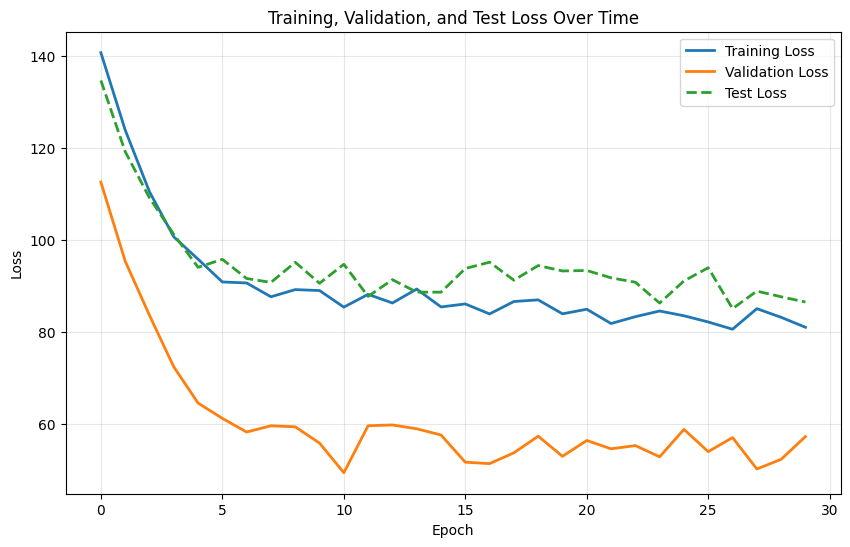

Running final test evaluation...
=== FINAL TEST RESULTS ===
Average Test Loss: 23.3175 ± 15.8726
Average Chamfer Distance: 23.3175
Test samples evaluated: 15


In [ ]:
def create_train_val_test_split(full_ds, val_ratio=0.10, test_ratio=0.20):
    """
    Creates train-validation-test split from the full dataset.
    Args:
        full_ds: Full dataset
        val_ratio: Proportion for validation (default 10%)
        test_ratio: Proportion for test (default 20%)
    Returns:
        train_ds, val_ds, test_ds
    """
    import torch
    import random

    n = len(full_ds)
    idxs = list(range(n))
    random.shuffle(idxs)

    # Calculate split points
    test_size = int(test_ratio * n)
    val_size = int(val_ratio * n)
    train_size = n - test_size - val_size

    train_idx = idxs[:train_size]                    # 70%
    val_idx = idxs[train_size:train_size + val_size] # 10%
    test_idx = idxs[train_size + val_size:]          # 20%

    train_ds = torch.utils.data.Subset(full_ds, train_idx)
    val_ds = torch.utils.data.Subset(full_ds, val_idx)
    test_ds = torch.utils.data.Subset(full_ds, test_idx)

    print(f"Training samples: {len(train_ds)} ({len(train_ds)/n*100:.1f}%)")
    print(f"Validation samples: {len(val_ds)} ({len(val_ds)/n*100:.1f}%)")
    print(f"Test samples: {len(test_ds)} ({len(test_ds)/n*100:.1f}%)")

    return train_ds, val_ds, test_ds

if __name__ == "__main__":
    # Paths
    DATA_ROOT = "/content/drive/MyDrive/Dental_Dataset"

    # Device
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", DEVICE)

    # Build datasets & loaders
    full_ds = DentalDataset(DATA_ROOT)

    # Create train-validation-test split (70:10:20)
    train_ds, val_ds, test_ds = create_train_val_test_split(full_ds, val_ratio=0.10, test_ratio=0.20)

    # Rest of your code remains unchanged...
    # Define data loaders
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,
                              num_workers=2, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=4, shuffle=False,
                            num_workers=2, collate_fn=collate_fn)
    test_loader = DataLoader(test_ds, batch_size=4, shuffle=False,
                             num_workers=2, collate_fn=collate_fn)

    # Instantiate model, optimizer
    model = DentureGenModel().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Training loop with validation monitoring
    train_losses = []
    val_losses = []
    test_losses = []
    EPOCHS = 30
    best_val_loss = float('inf')

    print("Starting training...")
    for epoch in range(1, EPOCHS + 1):
        # Training phase
        train_loss = train_epoch(model, train_loader, optimizer, DEVICE)
        train_losses.append(train_loss)

        # Validation phase evaluation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for pcs, borders, targets in val_loader:
                for pc, brd, tgt in zip(pcs, borders, targets):
                    pc_s = sample_pc(pc, 2048).to(DEVICE)
                    tgt_s = sample_pc(tgt, 2048).to(DEVICE)
                    out = model(pc_s, brd.to(DEVICE) if brd.numel() else None)
                    loss = chamfer_distance_simple(out, tgt_s)
                    if brd.numel():
                        border_pred = out[:brd.size(0)]
                        border_tgt = brd.to(DEVICE)
                        loss += 10.0 * l1_loss(border_pred, border_tgt)
                    val_loss += loss.item()
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        # Test phase evaluation (for monitoring purposes)
        test_loss = 0.0
        with torch.no_grad():
            for pcs, borders, targets in test_loader:
                for pc, brd, tgt in zip(pcs, borders, targets):
                    pc_s = sample_pc(pc, 2048).to(DEVICE)
                    tgt_s = sample_pc(tgt, 2048).to(DEVICE)
                    out = model(pc_s, brd.to(DEVICE) if brd.numel() else None)
                    loss = chamfer_distance_simple(out, tgt_s)
                    if brd.numel():
                        border_pred = out[:brd.size(0)]
                        border_tgt = brd.to(DEVICE)
                        loss += 10.0 * l1_loss(border_pred, border_tgt)
                    test_loss += loss.item()
        test_loss = test_loss / len(test_loader)
        test_losses.append(test_loss)

        print(f"Epoch {epoch}/{EPOCHS} - Train: {train_loss:.4f} - Val: {val_loss:.4f} - Test: {test_loss:.4f}")

        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_val_model.pth")
            print(f"→ New best validation loss: {val_loss:.4f}")

        # Save checkpoint every 10 epochs
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")

    # Save final model
    torch.save(model.state_dict(), "denture_model.pth")

    # Plot training, validation, and test loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss", linewidth=2)
    plt.plot(val_losses, label="Validation Loss", linewidth=2)
    plt.plot(test_losses, label="Test Loss", linewidth=2, linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training, Validation, and Test Loss Over Time")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Load best validation model for final test evaluation
    model.load_state_dict(torch.load("best_val_model.pth"))

    # FINAL TEST EVALUATION (call only once with best model!)
    final_results = test_model(model, test_loader, DEVICE)

    # Save test results
    with open("test_results.json", "w") as f:
        json.dump(final_results, f, indent=2)

    # Save all training metrics
    training_history = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_losses": test_losses,
        "best_val_loss": best_val_loss,
        "epochs": EPOCHS
    }

    with open("training_history.json", "w") as f:
        json.dump(training_history, f, indent=2)


**Inference and Deployment**

In [ ]:
def generate_prosthetic(model, scan_path, output_path="generated_prosthetic.stl", device="cuda"):
    """
    Generate a prosthetic from a new jaw scan and save it as an STL file.

    Args:
        model: Trained DentureGenModel
        scan_path: Path to the jaw scan STL file
        output_path: Path to save the generated prosthetic
        device: Device to run inference on
    """
    # Ensure model is in eval mode
    model.eval()

    # Load the jaw scan
    scan_mesh = trimesh.load(scan_path) #Load the path of the jaw scan inbetween the paranthesis
    jaw_pc = mesh_to_pc(scan_mesh).to(device)
    jaw_pc = sample_pc(jaw_pc, n_pts=2048)  # Same sampling as training

    # Generate prosthetic
    with torch.no_grad():
        out_pc = model(jaw_pc, None).cpu().numpy()  # [2048,3]

    # Reconstruct mesh using ConvexHull
    hull = ConvexHull(out_pc)
    prosthetic_mesh = trimesh.Trimesh(vertices=out_pc, faces=hull.simplices)

    # Save the generated prosthetic
    prosthetic_mesh.export(output_path)
    print(f"Generated prosthetic saved as '{output_path}'")

    return prosthetic_mesh

# Example usage for inference
if __name__ == "__main__":
    # Load the trained model
    model = DentureGenModel().to("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load("denture_model.pth"))

    # Generate prosthetic for a new patient
    new_scan_path = "/content/drive/MyDrive/new_patient_scan.stl"  # Update this path to include the file location of the inference scan
    prosthetic = generate_prosthetic(model, new_scan_path)


ValueError: string is not a file: `/content/drive/MyDrive/new_patient_scan.stl`